In [2]:
#Samples angle only every 40ms
#Added validation set
#Changing init
#Added leakyRelu

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import sys
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.models import Model
from keras.initializers import TruncatedNormal, Ones, Zeros
import time
from scipy.integrate import odeint
import pickle as pkl
import random

Using TensorFlow backend.


In [4]:
from simulation_tools import Servo, PRBS, simulation_init

In [5]:
#Layer and LightWeightModel are used instead of a Keras model because they have 
#less overhead and intermediate layers are easier to access. (Is initialized with a Keras model because it has a nice init)
#Simulation run time: 
#0.19070172309875488 s with keras
#0.034909725189208984 s with lightweight

#Interface with the lightweight model is the same as Keras for what we're using it for
#i.e. get_weights and set_weights act the same
class Layer:
    def __init__(self, weights):
        self.weights = weights
    
    def get_weights(self):
        return [np.array(self.weights[0]), np.array(self.weights[1])] #Return a deep copy of weights
    
    def set_weights(self, weights):
        self.weights = [np.array(weights[0]), np.array(weights[1])] #Make a deep copy of weights
        
class LightWeightModel:
    def __init__(self, keras_model):
        self.layers = []
        
        for i in range(len(keras_model.layers)):
            keras_weights = keras_model.layers[i].get_weights()
            if len(keras_weights) > 0:
                self.layers.append(Layer(keras_weights))
        
        self.intermediate_activation = [0, 0, 0, 0]
                
    def predict(self, input_vec):
        a = input_vec
        for i in range(len(self.layers)):
            w = self.layers[i].get_weights()[0]
            b = self.layers[i].get_weights()[1]
            z = np.matmul(a, w) + b
            if i != len(self.layers) - 1:
                a = self.leaky_relu(z)
                if i == 0:
                    self.intermediate_activation = a.flatten()
            else:
                a = z
        return a
    
    def leaky_relu(self, z):
        return np.where(z > 0, z, z * 0.3)      
    
    def count_params(self):
        param_count = 0
        for layer in self.layers:
            param_count += layer.get_weights()[0].size
            param_count += layer.get_weights()[1].size
        return param_count
    
class NeuralNetwork:
    def __init__(self):
        #Make a keras model
        keras_model = Sequential()
        keras_model.add(Dense(4, input_shape=(5,), 
                            kernel_initializer=TruncatedNormal(mean=0, stddev=1.0),
                            bias_initializer=TruncatedNormal(mean=0, stddev=1.0)))
        keras_model.add(LeakyReLU(alpha=0.3, name="intermediate_layer"))
        keras_model.add(Dense(3,
                            kernel_initializer=TruncatedNormal(mean=0, stddev=0.1),
                            bias_initializer=TruncatedNormal(mean=0, stddev=0.1)))
        
        #Convert into the lightweight model
        self.model = LightWeightModel(keras_model)
        self.stored_weights = None
        self.stored_weight_layer = None
        self.intermediate_index_1 = random.randint(0, 3)
        self.intermediate_index_2 = random.randint(0, 3)


    
    def predict(self, e, angle, velocity):
        #Add the activation from the hidden layer as input (for recurrence)
        prev_output = [self.model.intermediate_activation[self.intermediate_index_1], 
                       self.model.intermediate_activation[self.intermediate_index_2]]

        input_vec = np.array([np.concatenate(([e, angle, velocity], prev_output))])
        
        #Get the new Kp, Ki, and Kd values
        output = self.model.predict(input_vec)

        return output
        
        
    #Copy weights from a different neural network
    def copy_weights(self, source_neural_network):
        source_model = source_neural_network.model
        
        for i in range(len(self.model.layers)):
            #Get weights from layer (weights and bias in a list)
            new_weights = source_model.layers[i].get_weights()
            
            #If the list is empty (i.e. the layer is an activation layer in Keras)
            if len(new_weights) == 0:
                #Get weights from the next layer after (assuming it exists)
                new_weights = source_model.layers[i+1].get_weights()
                
            #Set the weights of the current model with the weights of the model we're copying from
            self.model.layers[i].set_weights(new_weights)
            
        self.set_intermediate_indices(source_neural_network.get_intermediate_indices())
    #Temporarily change a single weight by delta
    def temp_weight_change(self, layer_num, weight_num, index, delta):
        #Get the weights at layer_num
        temp_weights = self.model.layers[layer_num].get_weights()
        #Get another copy of the weights at layer_num (for restoring later)
        self.stored_weights = self.model.layers[layer_num].get_weights()
        
        #At weight_num (0 for weights, 1 for bias), at the index (tuple: i, j), add the delta
        temp_weights[weight_num][index] += delta
        #Set the weights at layer_num to the adjusted weights
        self.model.layers[layer_num].set_weights(temp_weights)
        #Store the layer number for which we changed the weights
        self.stored_weight_layer = layer_num
    
    #Undo the changes from temp_weight_change()
    def temp_weight_restore(self):
        #Restore the weights at the stored layer number with the stored weights
        self.model.layers[self.stored_weight_layer].set_weights(self.stored_weights)

    #Adjust the weights according to the weight_adjustment_list
    #weight_adjustment_list is determined through the levenberg-marquardt algorithm
    def adjust_weights(self, weight_adjustment_list):
        current_w = 0        
        layers = self.model.layers
        #The order of this loop is the same order as the jacobian for the weights is computed 
        #so the adjustment lits should be in the right order
        
        #Iterate through layers
        for layer_num, layer in enumerate(layers):
            temp_weights = []
            #Iterate through weights
            for weight in layer.get_weights():
                #Iterate through indices
                for index in np.ndindex(weight.shape):
                    #Adjust the weight at the index
                    weight[index] += weight_adjustment_list[current_w]
                    current_w += 1
                #Add the adjusted weight to the temp weight list
                temp_weights.append(weight)
            #Set the weights for the layer to the temp weight list (adjusted weights)
            self.model.layers[layer_num].set_weights(temp_weights)
            
    def get_intermediate_indices(self):
        return self.intermediate_index_1, self.intermediate_index_2
    
    def set_intermediate_indices(self, indices):
        self.intermediate_index_1 = indices[0]
        self.intermediate_index_2 = indices[1]

In [6]:
class PIDTuner:
    def __init__(self, servo_type, Kp, Ki, Kd, angle_delay=0, angle_sample_rate=1, saturation=110, command_delay=0):
        self.servo = Servo(servo_type, Kp, Ki, Kd)
        self.nn = NeuralNetwork()
        self.stored_nn = None
        self.angle_delay = angle_delay
        self.angle_sample_rate = angle_sample_rate
        self.saturation = saturation
        self.command_delay = command_delay
    
    #Simulate the response for timeseries T, inital conditions y0, setpoint r, disturbance d
    #use_nn: use the NN PID or not
    #return_y: return the angle of the servo or not
    def simulate(self, T, y0, r, d, use_nn=True, return_y=False):
        self.servo.PID.reset()
        self.servo.PID.update_gains(0.32, 0.06, 0.00879)
        dy = np.zeros(len(T))
        y = np.zeros(len(T))
        angle = np.zeros(len(T))
        u = np.zeros(len(T))
        
        dy[0] = y0[0] #servo velocity
        y[0] = y0[1] #servo angle
        
        angle[0:self.angle_delay+1] = y[0] * 180/math.pi + 180 + d[0] #IMU angle
        u[0:self.command_delay] = y[0]

        Kp_list = np.zeros(len(T))
        Ki_list = np.zeros(len(T))
        Kd_list = np.zeros(len(T))
        
        sampled_angle = angle[0]
        u_delay = u[0]

        for i in range(1, len(T)):

            #Sample angle at the angle sample rate
            if i % self.angle_sample_rate == 0:
                #Get delayed angle (if not enough data yet, just set to the initial condition)
                if i-1-self.angle_delay < 0:
                    sampled_angle = angle[0]
                else:
                    sampled_angle = angle[i-1-self.angle_delay]
                
            e = r[i] - sampled_angle

            if use_nn:
                e_norm = self.normalize(abs(e), 0, 90) #error
                angle_norm = self.normalize(abs(sampled_angle) - 180, 0, 90) #sampled angle
#                 u_norm = self.normalize(u_delay, -math.pi/2, math.pi/2) #previous u_delay
                if i >= 2:
                    velocity = self.normalize(abs((y[i-1] - y[i-2])/(T[i-1] - T[i-2])), 0, 10) #velocity
                else:
                    velocity = 0
                    
                Kp, Ki, Kd = np.absolute(self.nn.predict(e_norm, angle_norm, velocity).flatten()) #Get gains from NN

                Kp_list[i] = Kp
                Ki_list[i] = Ki
                Kd_list[i] = Kd
                assert not math.isnan(Kp) and not math.isnan(Ki) and not math.isnan(Kd), "NaN Neural Network output"
 
                self.servo.PID.update_gains(Kp, Ki, Kd) #Update the gains in the PID controller
            
            #get control signal by setting error and current time (t = [t_prev, t_cur])
            u[i] = self.servo.PID.update(e, T[i])

            #convert to deg by multiplying by 360/4096
            #Saturate the command (signal saturates at +/- 12V)
            u[i] = min(max(u[i], -self.saturation * 360/4096), self.saturation * 360/4096)

            #control signal is added to previous angle, rather than just setting the angle (convert to radians)
            u[i] = u[i] * math.pi/180 + y[i-1] 
                    #Get delayed command (if not enough data yet, just set to the initial condition)
            if i - self.command_delay < 0:
                u_delay = u[0]
            else:
                u_delay = u[i-self.command_delay]
                
            #Run odeint, get next state
            _, state = odeint(self.servo.ode, [dy[i-1], y[i-1]], [T[i-1], T[i]], args=(u_delay,)) #simulate step using odeint

            #Compute next IMU angle using next state and disturbance
            #Convert back to degrees and add 180 degrees and disturbance
            angle[i] = state[1] * 180/math.pi + 180 + d[i] 

            # state, angle[i] = self.servo.simulate_step([dy[i-1], y[i-1]], sampled_angle, [T[i-1], T[i]], r[i], d[i])
            
            #Set servo velocity and angle to the new state
            dy[i] = state[0]
            y[i] = state[1]
            
            
        if return_y:
            return angle, (Kp_list, Ki_list, Kd_list), y
        else:
            return angle, (Kp_list, Ki_list, Kd_list)
    

    def compute_jacobian(self, T, y0, r, d):
        #Jacobian is timesteps x number of weights
        jacobian = np.empty((len(T), self.nn.model.count_params()))
        
        current_w = 0
        
        #Get IMU angle by simulating with current weights
        y1, _ = self.simulate(T, y0, r, d)

        #Change each weight by delta and simulate
        layers = self.nn.model.layers
        for layer_num, layer in enumerate(layers):
            for weight_num, weight in enumerate(layer.get_weights()):
                for index in np.ndindex(weight.shape):

                    wij = weight[index]
                    epsilon = max(1, abs(wij)) * math.sqrt(sys.float_info.epsilon)        
                    #Change the weight by epsilon
                    self.nn.temp_weight_change(layer_num, weight_num, index, epsilon)
                    
                    #Get IMU angle by simulating with changed weight
                    y2, _ = self.simulate(T, y0, r, d)
                    
                    #Undo the change
                    self.nn.temp_weight_restore()
                    
                    #Compute derivative for changed weight
                    for t in range(len(T)):
                        jacobian[t, current_w] = (y1[t] - y2[t])/epsilon
                    current_w += 1
            
        return jacobian, y1
    
    def store_nn(self):
        self.stored_nn = NeuralNetwork()
        self.stored_nn.copy_weights(self.nn)
        
    def restore_nn(self):
        self.nn = self.stored_nn
        
    def normalize(self, x, min_x, max_x):
        return (x - min_x)/(max_x - min_x)

In [7]:
def print_weights(neural_network):
    model = neural_network.model
    #To copy paste into C#
    weight_names = ['w1', 'b1', 'w2', 'b2']
    w_index = 0
    for layer in model.layers:
        for w in layer.get_weights():
            print("Matrix<double>", weight_names[w_index], "= M.DenseOfArray(new double[,]{", end='')
            for i, row in enumerate(w):
                if type(row) is not np.float32:
                    print("{", end='')
                    for j in row:
                        print(str(j) + ",", end='')
                    print("},", end='')
                else:
                    if i == 0:
                        print("{",end='')
                    print(str(row) + ",", end='')
                    if i == len(w) - 1:
                        print("}",end='')
            print("});")
            w_index += 1
    print("intermediate_index_1 =" + str(neural_network.get_intermediate_indices()[0]) + ";")
    print("intermediate_index_2 =" + str(neural_network.get_intermediate_indices()[1]) + ";")



In [8]:
#Get an array of time values based on the timestamp column from the real data df
#Probably doesn't work if you ran the simulation and cross over to the next day (go home!)
def get_T(df):
    from datetime import datetime
    T = []
    dt_str = df.iloc[0]['timestamp'].split(':')
    temp = dt_str.pop()
    dt_str.extend(temp.split('.'))
    first_time = datetime(2019, 8, 12, int(dt_str[0]), int(dt_str[1]), int(dt_str[2]), 
                               int(dt_str[3]) * 1000)
    for row in df.iterrows():
        dt_str = row[1]['timestamp'].split(':')
        temp = dt_str.pop()
        dt_str.extend(temp.split('.'))
        cur_time = datetime(2019, 8, 12, int(dt_str[0]), int(dt_str[1]), int(dt_str[2]), 
                                   int(dt_str[3]) * 1000)
        delta = (cur_time - first_time)
        T.append(round(delta.seconds + delta.microseconds/1000/1000, 3))
    T = np.array(T)
    
    return T

#Find the index in time series T that contains time closest to t
def get_closest_time_index(t, T):

    for i in range(len(T)):
        if t <= T[i] and i == 0:
            return i
        if t < T[i] and t > T[i-1]:
            return i
    return len(T) - 1

In [9]:
def tune_simulation(real_data_file_name, use_nn, trained_model_file_name=None):
    assert use_nn == (trained_model_file_name is not None)
    df = pd.read_csv(real_data_file_name, sep=',')
    angle_actual = np.array(df['phi']) #Angle from setpoint
    y_actual = (df['rot_pos'] - 2048) * math.pi/2048 #Servo position in radians
    T_actual = get_T(df) #Time for actual

    grid = {
        'dt': [0.002, 0.005, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05],
        'angle_delay': [0.01, 0.03, 0.06, 0.09, 0.12, 0.15],
        'saturation': [80, 90, 100, 110, 120, 130, 140],
        'command_delay': [0.002, 0.005, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05]
    }

    best_params = {
        'dt': 0,
        'angle_delay': 0,
        'saturation': 0,
        'command_delay': 0
    }
    best_mse_angle = None
    best_mse_y = None
    rot_tuner = PIDTuner("rotation", 0.32, 0.06, 0.00879)

    if use_nn:
        rot_tuner.nn = pkl.load(open(trained_model_file_name, 'rb'))['model']

        
    total_iters = len(grid['dt']) * len(grid['angle_delay']) * len(grid['saturation']) * len(grid['command_delay'])
    current_iter = 0

    #Grid search of best params
    for dt in grid['dt']:
        for ad in grid['angle_delay']:
            for saturation in grid['saturation']:
                for cd in grid['command_delay']:
                    angle_sample_rate = 1
                    angle_delay = int(ad//dt)
                    command_delay = int(cd//dt)

                    rot_tuner.angle_delay = angle_delay
                    rot_tuner.angle_sample_rate = angle_sample_rate
                    rot_tuner.saturation = saturation
                    rot_tuner.command_delay = command_delay


                    #Test used is to set the angle of the servo to -pi/2
                    #then turn the PID on so that it tries to return to 0 (and the IMU reads 180)
                    T_sim = np.arange(0, T_actual[-1], dt) #Length of the simulation should be the same as the real
                    r = np.ones(len(T_sim)) * 180 #Setpoint
                    d = np.zeros(len(T_sim)) #No disturbance
                    y0 = [0, -math.pi/2] #Initial angle of the servo is -pi/2 radians
                    angle_sim, gains_sim, y_sim = rot_tuner.simulate(T_sim, y0, r, d, use_nn=use_nn, return_y=True)

                    #Calculate the mse between the simulated and actual for IMU angle and servo position
                    mse_angle = 0
                    mse_y = 0
                    for i in range(len(T_actual)):
                        mse_angle += (angle_actual[i] - angle_sim[get_closest_time_index(T_actual[i], T_sim)])**2
                        mse_y += (y_actual[i] - y_sim[get_closest_time_index(T_actual[i], T_sim)])**2
                    mse_angle = mse_angle/len(T_actual)
                    mse_y = mse_y/len(T_actual)

                    #Find best params based on mse
                    if (best_mse_angle is None and best_mse_y is None) or (mse_angle < best_mse_angle and mse_y < best_mse_y):
                        best_mse_angle = mse_angle
                        best_mse_y = mse_y
                        best_params['dt'] = dt
                        best_params['angle_delay'] = ad
                        best_params['saturation'] = saturation
                        best_params['command_delay'] = cd
                    current_iter+=1

                    print("{0:.3f}%, ".format(current_iter/total_iters * 100), end='')

    print("Done tuning, best params:")
    print(best_params)
    
def test_actual_vs_sim(real_data_file_name, best_params, use_nn, trained_model_file_name=None):
    assert use_nn == (trained_model_file_name is not None)

    df = pd.read_csv(real_data_file_name, sep=',')
    angle_actual = np.array(df['phi']) #Angle from setpoint
    y_actual = (df['rot_pos'] - 2048) * math.pi/2048 #Servo position in radians
    T_actual = get_T(df) #Time for actual
    gains_actual = df[['Kp_phi', 'Ki_phi', 'Kd_phi']]

    dt = best_params['dt']
    angle_sample_rate = 1
    angle_delay = int(best_params['angle_delay']//dt)
    saturation = best_params['saturation']
    command_delay = int(best_params['command_delay']//dt)

    rot_tuner = PIDTuner("rotation", 0.32, 0.06, 0.00879, angle_delay, angle_sample_rate, saturation, command_delay)
    if use_nn:
        rot_tuner.nn = pkl.load(open(trained_model_file_name, 'rb'))['model']
        print_weights(rot_tuner.nn)

    #Test used is to set the angle of the servo to -pi/2
    #then turn the PID on so that it tries to return to 0 (and the IMU reads 180)
    T_sim = np.arange(0, T_actual[-1], dt)
    r = np.ones(len(T_sim)) * 180 #Setpoint
    d = np.zeros(len(T_sim)) #No disturbance
    y0 = [0, -math.pi/2] #Initial angle of the servo is -pi/2 radians (-90 degrees)
    angle_sim, gains_sim, y_sim = rot_tuner.simulate(T_sim, y0, r, d, use_nn=use_nn, return_y=True)

    plt.plot(T_actual, angle_actual)
    plt.plot(T_sim, angle_sim)
    plt.plot(T_sim, r)

    plt.xlabel("Time (s)")
    plt.ylabel("IMU angle (degrees)")
    plt.legend(['Actual Angle', 'Simulated Angle', 'Setpoint'])
    plt.title("IMU angle versus time for the actual and simulated rotation servo with default gains")
    plt.show()

    plt.plot(T_actual, y_actual)
    plt.plot(T_sim, y_sim)
    plt.xlabel("Time (s)")
    plt.ylabel("Servo position (radians)")
    plt.legend(['Actual Servo Pos', 'Simulated Servo Pos'])
    plt.title("Servo position versus time for the actual and simulated rotation servo with default gains")
    plt.show()
    
    if use_nn:
        plt.plot(T_actual, gains_actual['Kp_phi'])
        plt.plot(T_sim, gains_sim[0])
        plt.xlabel("Time (s)")
        plt.ylabel("Kp value")
        plt.legend(['Actual Kp', 'Simulated Kp'])
        plt.title("Kp over time for the actual and simulated rotation servo")
        plt.show()

        plt.plot(T_actual, gains_actual['Ki_phi'])
        plt.plot(T_sim, gains_sim[1])
        plt.xlabel("Time (s)")
        plt.ylabel("Ki value")
        plt.legend(['Actual Ki', 'Simulated Ki'])
        plt.title("Ki over time for the actual and simulated rotation servo")
        plt.show()

        plt.plot(T_actual, gains_actual['Kd_phi'])
        plt.plot(T_sim, gains_sim[2])
        plt.xlabel("Time (s)")
        plt.ylabel("Kd value")
        plt.legend(['Actual Kd', 'Simulated Kd'])
        plt.title("Kd over time for the actual and simulated rotation servo")
        plt.show()

# File locations

In [10]:
fname_actual_data_no_nn = 'NN PID Results/Step Responses/step_response_no_nn.txt'
fname_actual_data_nn = 'NN PID Results/data_to_test_difference_sim_actual.txt'
fname_sim_model = 'NN PID Results/model_to_test_difference_sim_actual.pkl'

# Tuning the simulation

In [16]:
tune_simulation(fname_actual_data_no_nn, use_nn=False)

0.037%, 0.074%, 0.112%, 0.149%, 0.186%, 0.223%, 0.260%, 0.298%, 0.335%, 0.372%, 0.409%, 0.446%, 0.484%, 0.521%, 0.558%, 0.595%, 0.632%, 0.670%, 0.707%, 0.744%, 0.781%, 0.818%, 0.856%, 0.893%, 0.930%, 0.967%, 1.004%, 1.042%, 1.079%, 1.116%, 1.153%, 1.190%, 1.228%, 1.265%, 1.302%, 1.339%, 1.376%, 1.414%, 1.451%, 1.488%, 1.525%, 1.562%, 1.600%, 1.637%, 1.674%, 1.711%, 1.749%, 1.786%, 1.823%, 1.860%, 1.897%, 1.935%, 1.972%, 2.009%, 2.046%, 2.083%, 2.121%, 2.158%, 2.195%, 2.232%, 2.269%, 2.307%, 2.344%, 2.381%, 2.418%, 2.455%, 2.493%, 2.530%, 2.567%, 2.604%, 2.641%, 2.679%, 2.716%, 2.753%, 2.790%, 2.827%, 2.865%, 2.902%, 2.939%, 2.976%, 3.013%, 3.051%, 3.088%, 3.125%, 3.162%, 3.199%, 3.237%, 3.274%, 3.311%, 3.348%, 3.385%, 3.423%, 3.460%, 3.497%, 3.534%, 3.571%, 3.609%, 3.646%, 3.683%, 3.720%, 3.757%, 3.795%, 3.832%, 3.869%, 3.906%, 3.943%, 3.981%, 4.018%, 4.055%, 4.092%, 4.129%, 4.167%, 4.204%, 4.241%, 4.278%, 4.315%, 4.353%, 4.390%, 4.427%, 4.464%, 4.501%, 4.539%, 4.576%, 4.613%, 4.650%, 

35.045%, 35.082%, 35.119%, 35.156%, 35.193%, 35.231%, 35.268%, 35.305%, 35.342%, 35.379%, 35.417%, 35.454%, 35.491%, 35.528%, 35.565%, 35.603%, 35.640%, 35.677%, 35.714%, 35.751%, 35.789%, 35.826%, 35.863%, 35.900%, 35.938%, 35.975%, 36.012%, 36.049%, 36.086%, 36.124%, 36.161%, 36.198%, 36.235%, 36.272%, 36.310%, 36.347%, 36.384%, 36.421%, 36.458%, 36.496%, 36.533%, 36.570%, 36.607%, 36.644%, 36.682%, 36.719%, 36.756%, 36.793%, 36.830%, 36.868%, 36.905%, 36.942%, 36.979%, 37.016%, 37.054%, 37.091%, 37.128%, 37.165%, 37.202%, 37.240%, 37.277%, 37.314%, 37.351%, 37.388%, 37.426%, 37.463%, 37.500%, 37.537%, 37.574%, 37.612%, 37.649%, 37.686%, 37.723%, 37.760%, 37.798%, 37.835%, 37.872%, 37.909%, 37.946%, 37.984%, 38.021%, 38.058%, 38.095%, 38.132%, 38.170%, 38.207%, 38.244%, 38.281%, 38.318%, 38.356%, 38.393%, 38.430%, 38.467%, 38.504%, 38.542%, 38.579%, 38.616%, 38.653%, 38.690%, 38.728%, 38.765%, 38.802%, 38.839%, 38.876%, 38.914%, 38.951%, 38.988%, 39.025%, 39.062%, 39.100%, 39.137%, 3

69.010%, 69.048%, 69.085%, 69.122%, 69.159%, 69.196%, 69.234%, 69.271%, 69.308%, 69.345%, 69.382%, 69.420%, 69.457%, 69.494%, 69.531%, 69.568%, 69.606%, 69.643%, 69.680%, 69.717%, 69.754%, 69.792%, 69.829%, 69.866%, 69.903%, 69.940%, 69.978%, 70.015%, 70.052%, 70.089%, 70.126%, 70.164%, 70.201%, 70.238%, 70.275%, 70.312%, 70.350%, 70.387%, 70.424%, 70.461%, 70.499%, 70.536%, 70.573%, 70.610%, 70.647%, 70.685%, 70.722%, 70.759%, 70.796%, 70.833%, 70.871%, 70.908%, 70.945%, 70.982%, 71.019%, 71.057%, 71.094%, 71.131%, 71.168%, 71.205%, 71.243%, 71.280%, 71.317%, 71.354%, 71.391%, 71.429%, 71.466%, 71.503%, 71.540%, 71.577%, 71.615%, 71.652%, 71.689%, 71.726%, 71.763%, 71.801%, 71.838%, 71.875%, 71.912%, 71.949%, 71.987%, 72.024%, 72.061%, 72.098%, 72.135%, 72.173%, 72.210%, 72.247%, 72.284%, 72.321%, 72.359%, 72.396%, 72.433%, 72.470%, 72.507%, 72.545%, 72.582%, 72.619%, 72.656%, 72.693%, 72.731%, 72.768%, 72.805%, 72.842%, 72.879%, 72.917%, 72.954%, 72.991%, 73.028%, 73.065%, 73.103%, 7

W0819 16:32:42.785903  3048 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 16:32:42.798868  3048 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 16:32:42.799867  3048 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0819 16:32:42.825767  3048 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 16:32:42.827809  3048 depre

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.660198,-0.50707865,-0.5734708,0.9746839,},{1.1738548,0.9270595,0.30862525,-1.0943176,},{-0.51630235,0.6186662,-0.74783623,0.48259217,},{-0.9951606,-0.39039814,-0.42035758,-0.21496727,},{-0.24691078,1.2046343,0.7027062,-0.36883187,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{-0.43572325,-0.56301135,1.0449543,-0.60138285,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.028389117,-0.011143724,-0.044879466,},{0.05557218,-0.07039982,0.10108731,},{0.10805359,-0.105353944,-0.05018228,},{0.054473963,0.1610201,0.19729903,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{0.152453,-0.02680105,-0.117906205,}});
intermediate_index_1 =0;
intermediate_index_2 =3;


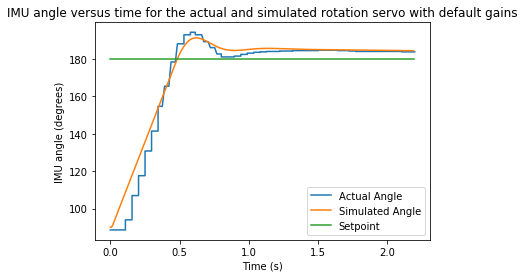

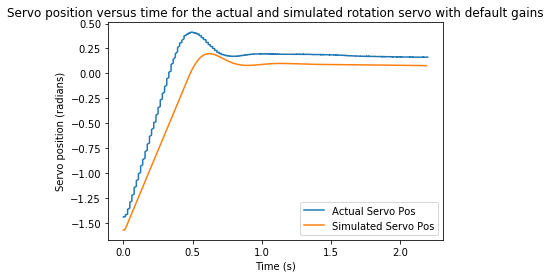

In [9]:
best_params = {'dt': 0.008, 'angle_delay': 0.12, 'saturation': 100, 'command_delay': 0.008} #From tuning above
test_actual_vs_sim(fname_actual_data_no_nn, best_params, use_nn=False)

# Neural Network Training

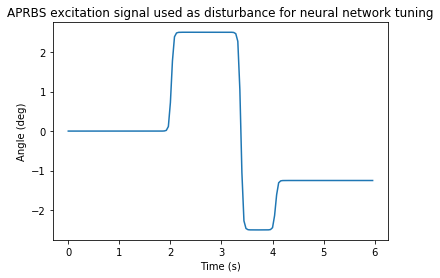

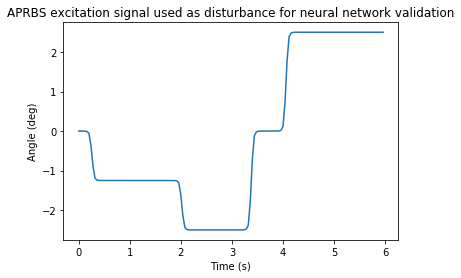

Samples: 100
Starting trial 0
Iteration: 0 | mse: 1.0517670480577597 | adj_mse: 0.6519412507692652
Iteration: 1 | mse: 0.6519412507692254 | adj_mse: 0.5650780822890183
Iteration: 2 | mse: 0.5650780822890275 | adj_mse: 6.836285524317337
Iteration: 3 | mse: 0.5650780822890275 | adj_mse: 0.8364861826299558
Iteration: 4 | mse: 0.5650780822890275 | adj_mse: 0.6977343078120423
Iteration: 5 | mse: 0.5650780822890275 | adj_mse: 0.5791827700011241
Iteration: 6 | mse: 0.5650780822890275 | adj_mse: 0.5557384325341789
Iteration: 7 | mse: 0.5557384325342359 | adj_mse: 0.5733618453485683
Iteration: 8 | mse: 0.5557384325342359 | adj_mse: 0.5593509216480779
Iteration: 9 | mse: 0.5557384325342359 | adj_mse: 0.5558657792820547
Iteration: 10 | mse: 0.5557384325342359 | adj_mse: 0.5558359172611775
Iteration: 11 | mse: 0.5557384325342359 | adj_mse: 0.5558613951324037
Iteration: 12 | mse: 0.5557384325342359 | adj_mse: 0.5557694257937635
Iteration: 13 | mse: 0.5557384325342359 | adj_mse: 0.5557445843569139
I

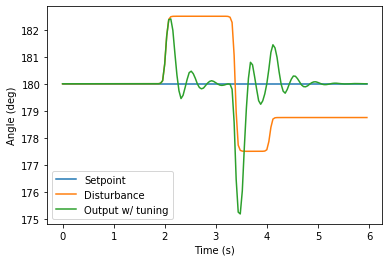

Matrix<double> w1 = M.DenseOfArray(new double[,]{{0.132051,0.702912,-0.94238704,0.024609039,},{-0.9332614,0.085282415,1.4289898,-0.96101123,},{0.02754234,-0.5592783,1.6515357,0.016667288,},{0.40037605,1.0338398,-0.08806411,0.22337021,},{1.1923336,-1.3323098,-0.9444226,-0.7197354,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{-1.0889388,0.45196244,-0.12977815,0.589793,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.29942846,0.055784166,-0.19396558,},{-0.08352026,0.0631181,0.28690526,},{-0.16222683,-0.01336583,-0.31542447,},{-0.04519736,0.02226185,-0.052958302,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.26143473,0.0023953943,-0.031500023,}});
intermediate_index_1 =2;
intermediate_index_2 =3;
Old best: None | New best: 0.5557384325342359
Samples: 150
Starting trial 1
Iteration: 0 | mse: 48.02568105405685 | adj_mse: 41.10904863769936
Iteration: 1 | mse: 41.10904863769936 | adj_mse: 12.48318215406401
Unable to invert A
Samples: 150
Starting trial 1
Iteration

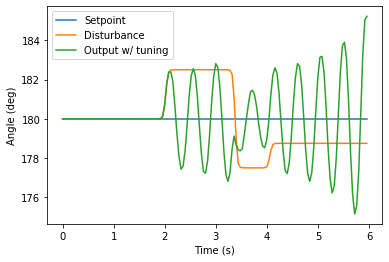

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.36828798,0.8951892,-0.33242196,-0.15010446,},{0.9881714,1.7950357,-1.1547731,0.41352302,},{0.08087497,0.8873849,0.6367787,0.20855184,},{-0.2526645,-0.89205104,-0.63670635,-0.4825338,},{-0.26421785,0.3436569,0.35975063,1.0186526,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{-1.1170126,1.342399,-1.209879,0.6765016,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{-0.038863376,-0.09825032,-0.25678986,},{0.4040358,0.038060963,0.16421874,},{-0.079236545,0.049469054,0.19405718,},{-0.023782205,-0.038708568,-0.25533915,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.02776289,-0.06900128,-0.10528771,}});
intermediate_index_1 =0;
intermediate_index_2 =0;
Samples: 150
Starting trial 2
Iteration: 0 | mse: 48.71830409427478 | adj_mse: 33.80003815388882
Iteration: 1 | mse: 33.80003815388882 | adj_mse: 26.518589011071292
Iteration: 2 | mse: 26.518589011071292 | adj_mse: 50.2711693910684
Iteration: 3 | mse: 26.5185890110712

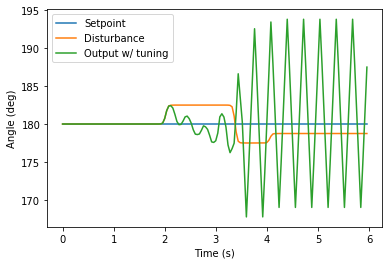

Matrix<double> w1 = M.DenseOfArray(new double[,]{{0.567277,1.0666789,-1.6041329,-0.83610636,},{1.0082996,-0.82181513,1.204176,-0.8725494,},{-0.33787304,0.33828682,-0.5637762,-0.56476855,},{-0.9484464,-1.0926504,0.89565635,-0.012019699,},{-0.6922166,-1.0936549,-0.41971558,-0.52947646,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.84558886,-0.48135704,-0.45900488,-1.0059125,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.04501238,-0.46115172,-0.35143793,},{-0.51624686,0.102960706,1.4556631,},{0.0035894802,0.14387296,-0.25446147,},{-0.0913438,0.1413457,0.60774326,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.067720614,-0.37460312,0.4621688,}});
intermediate_index_1 =3;
intermediate_index_2 =3;
Samples: 150
Starting trial 3
Iteration: 0 | mse: 49.59527128259252 | adj_mse: 37.354745048650244
Iteration: 1 | mse: 33.58838593105287 | adj_mse: 32.4229004438351
Iteration: 2 | mse: 25.407755866924163 | adj_mse: 26.753802356144142
Iteration: 3 | mse: 25.40775586692

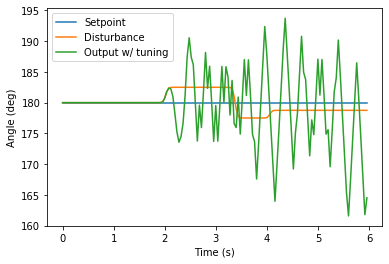

Matrix<double> w1 = M.DenseOfArray(new double[,]{{0.27225754,1.3562275,0.9081031,-0.3597778,},{-1.748028,1.3296945,-0.7976605,-1.1212363,},{-0.9540418,-1.8140748,1.7689039,-0.50446165,},{-0.82637817,-0.98874855,1.6780932,0.280532,},{-0.05952591,-1.0707395,-0.6959157,-1.5349493,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.4013146,0.5631736,0.52680784,0.4945682,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{-0.74827284,-0.041340943,-0.40968698,},{0.5223817,1.0151268,0.0682168,},{-0.34229723,-0.6343719,-0.33940232,},{-1.2648193,-0.14948182,-0.6010638,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.9180635,0.792088,0.27259645,}});
intermediate_index_1 =0;
intermediate_index_2 =2;
Samples: 150
Starting trial 4
Iteration: 0 | mse: 0.6583528097031278 | adj_mse: 0.6402365423749911
Iteration: 1 | mse: 0.6402368363520907 | adj_mse: 2.5054381249963096
Iteration: 2 | mse: 0.6402368363520907 | adj_mse: 0.6106330678845171
Iteration: 3 | mse: 0.6106305708650134 | adj_m

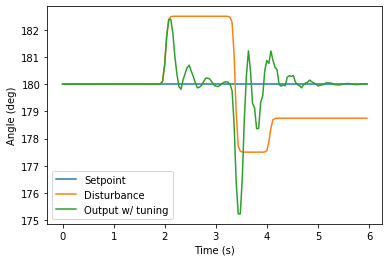

Matrix<double> w1 = M.DenseOfArray(new double[,]{{1.3984977,-1.1644185,1.0778946,0.5846603,},{-1.3125317,0.32993433,1.5199388,-0.08115828,},{-0.6762567,1.8771038,0.1557484,0.16003643,},{-0.14613983,-1.0469463,-1.3007567,-0.849498,},{-1.2559407,-1.1118828,-0.52442294,-1.6406817,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.708041,0.91220343,0.09245651,-0.8596813,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.08542047,0.14897564,-0.2678145,},{-0.007413452,-0.042972084,0.35422996,},{0.017634064,0.11373352,-0.4121669,},{-0.013582068,-0.042146534,-0.10248185,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{0.17729801,-0.11498875,-0.020023707,}});
intermediate_index_1 =0;
intermediate_index_2 =3;
Old best: 0.5557384325342359 | New best: 0.555664832849442
Samples: 150
Starting trial 5
Iteration: 0 | mse: 49.13717017130526 | adj_mse: 50.52191632768195
Iteration: 1 | mse: 49.13717017130526 | adj_mse: 53.57187846895519
Iteration: 2 | mse: 49.13717017130526 | adj_mse:

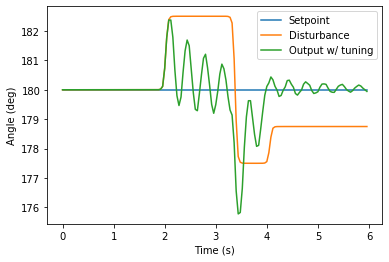

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.7221465,-0.89307594,0.30910772,-0.19272846,},{-0.99811727,0.06319138,1.0534111,1.7323312,},{-0.094912775,0.6283128,0.2539463,-1.2736027,},{-0.89058316,-0.30255407,-0.6128652,1.5747603,},{-0.69726497,0.3300804,0.9453506,-0.22062172,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.59154165,0.7237234,-0.5761321,-0.75188035,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.03731174,0.06181037,0.10145873,},{-0.060339637,-0.09108766,-0.12955938,},{0.052800663,-0.004640513,0.07928431,},{0.09602058,-0.17848693,-0.12579073,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.15550704,0.042604513,0.0060703517,}});
intermediate_index_1 =1;
intermediate_index_2 =2;
Samples: 150
Starting trial 6
Iteration: 0 | mse: 52.48639292330904 | adj_mse: 46.31029628663889
Iteration: 1 | mse: 46.31029628662297 | adj_mse: 47.277738916044626
Iteration: 2 | mse: 46.31029628662297 | adj_mse: 11.574795290852386
Iteration: 3 | mse: 11.5747952

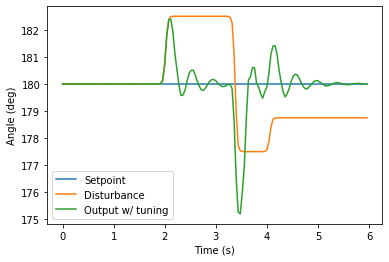

Matrix<double> w1 = M.DenseOfArray(new double[,]{{0.10040467,0.04287648,0.27952713,0.84358394,},{1.0890006,-0.5543949,0.5137023,1.1786404,},{-0.16839123,0.64651996,1.3716575,0.2110878,},{-0.47872484,-1.0950985,0.48021376,0.6728699,},{-1.2560335,1.3566883,1.7933444,1.9226218,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{-0.36349595,-1.2819612,-0.5007573,1.0250149,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.2530282,0.104343645,0.49595672,},{-0.12549086,-0.029852849,0.54631597,},{0.59122795,0.0035344546,-0.6749412,},{0.48370385,-0.056361385,-0.62335116,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.24962579,-0.04857282,-0.22734791,}});
intermediate_index_1 =2;
intermediate_index_2 =1;
Samples: 150
Starting trial 7
Iteration: 0 | mse: 49.68028198735304 | adj_mse: 48.68644305383788
Iteration: 1 | mse: 48.68644305384268 | adj_mse: 47.59761506066913
Iteration: 2 | mse: 47.597615060609414 | adj_mse: 82.5975223267484
Iteration: 3 | mse: 47.597615060609414 | ad

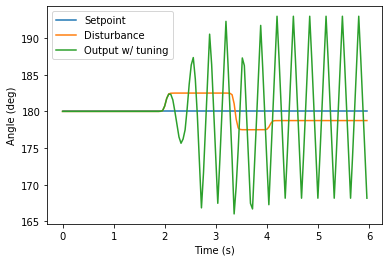

Matrix<double> w1 = M.DenseOfArray(new double[,]{{1.0930978,1.140383,0.87549555,-0.7303174,},{-0.7451155,-0.9402399,1.4693251,-0.4353783,},{1.0527889,0.27267873,-0.06916693,-0.5741682,},{-0.67739797,-0.19733147,-1.4523598,0.45984155,},{1.078014,-0.30060995,0.79721534,-0.59421575,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.5613507,-0.9518778,1.6443913,1.4268749,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{-0.13472487,-0.11528703,0.11855169,},{-0.20913668,0.022892207,-0.10197498,},{0.04257722,-0.17905152,1.2289487,},{-0.29104382,-0.26142853,0.23401417,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.24153535,0.150942,0.45789462,}});
intermediate_index_1 =3;
intermediate_index_2 =1;
Samples: 150
Starting trial 8
Iteration: 0 | mse: 32.74181570517638 | adj_mse: 47.8864654349334
Iteration: 1 | mse: 32.74181570517638 | adj_mse: 37.412147555769735
Iteration: 2 | mse: 32.74181570517638 | adj_mse: 37.412147555769735
Iteration: 3 | mse: 32.74181570517638 | adj_m

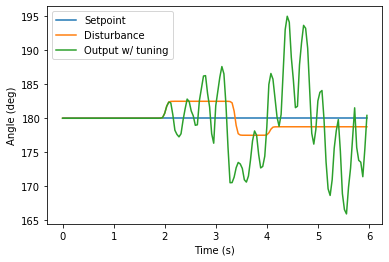

Matrix<double> w1 = M.DenseOfArray(new double[,]{{0.03952831,0.9179559,-0.2534402,1.997113,},{1.7515318,1.1763121,-0.5851438,0.78968245,},{0.37797368,0.0040462976,-0.48238617,-0.27570707,},{0.19182304,0.3360725,-1.6574789,0.37305886,},{1.4755769,-0.40143132,1.0295967,0.6983648,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{-0.3260587,-0.98928267,1.4043659,-1.1432151,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{-0.02589777,0.049885307,-0.033266295,},{-0.040673107,-0.038094055,-0.040617175,},{-0.057963982,-0.030088156,0.034076214,},{-0.04955253,0.07055335,0.069860324,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{0.19850245,-0.058697015,-0.12175416,}});
intermediate_index_1 =3;
intermediate_index_2 =2;
Samples: 150
Starting trial 9
Iteration: 0 | mse: 71.78569108695363 | adj_mse: 61.36018993520884
Iteration: 1 | mse: 61.36018993520629 | adj_mse: 99.68777972307929
Iteration: 2 | mse: 61.36018993520629 | adj_mse: 64.46468614420884
Iteration: 3 | mse: 61.36018993

KeyboardInterrupt: 

In [13]:
# best_params = {'dt': 0.008, 'angle_delay': 0.12, 'saturation': 100, 'command_delay': 0.008} #No NN PID
# best_params = {'dt': 0.01, 'angle_delay': 0.15, 'saturation': 90, 'command_delay': 0.002} #With NN PID
best_params = {'dt': 0.04, 'angle_delay': 0.15, 'saturation': 100, 'command_delay': 0.002} #With NN PID


aprbs_amp = 5
dt = best_params['dt']
angle_sample_rate = 1
angle_delay = int(best_params['angle_delay']//dt)
saturation = best_params['saturation']
command_delay = int(best_params['command_delay']//dt)
rot_tuner = PIDTuner("rotation", 1, 1, 1, angle_delay, angle_sample_rate, saturation, command_delay)
T, r, d, d_val, y0 = simulation_init(dt, 6, aprbs_hold=2.0, aprbs_amp=aprbs_amp, butter_cutoff=5)

plt.plot(T, d)
plt.title("APRBS excitation signal used as disturbance for neural network tuning")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.show()

plt.plot(T, d_val)
plt.title("APRBS excitation signal used as disturbance for neural network validation")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.show()

max_trials = 100

sample_increase = 100
samples = sample_increase


best_mse = None
trial = 0


while(trial < max_trials):
    try:
        #Reinitialize the neural network at the beginning of each trial
        rot_tuner.nn = NeuralNetwork()
        prev_adj_mse = None
        iters = 0
        damping_factor = 10
        print("Samples:", samples)
        print("Starting trial", trial)
        trial_finished = False
        convergence_double_check = False

        while(not trial_finished):

            #Compute jacobian
            J, y = rot_tuner.compute_jacobian(T[:samples], y0, r[:samples], d[:samples]) 

            #Get error of output without weight change
            error = y - r[:samples] 


            #Simulate whole signal before weight change
            y_full_sig, _ = rot_tuner.simulate(T, y0, r, d) 
            y_full_sig_val, _ = rot_tuner.simulate(T, y0, r, d_val)
            #Calculate mse of output without weight change
            mse_train = np.sum(np.square(y_full_sig - r))/len(T)
            mse = (mse_train + np.sum(np.square(y_full_sig_val - r))/len(T))/2
#             assert mse_train < aprbs_amp

            try_solve_levenberg = True
            while(try_solve_levenberg):
                #Compute adjustment amount
                A = np.matmul(np.transpose(J), J) + damping_factor * np.identity(J.shape[1])
                B = np.matmul(np.transpose(J), (error))
                adjustment = np.matmul(np.linalg.inv(A), B) 

                #Store a copy of the current neural network before adjusting the weights
                rot_tuner.store_nn()
                rot_tuner.nn.adjust_weights(adjustment)

                #Simulate with the adjusted weights
                y_adj, _ = rot_tuner.simulate(T, y0, r, d) 
                y_adj_val, _ = rot_tuner.simulate(T, y0, r, d_val)

                #Calculate mse of output with weight change
                adj_mse = (np.sum(np.square(y_adj - r))/len(T) + np.sum(np.square(y_adj_val - r))/len(T))/2
                print("Iteration:", iters, "| mse:", mse, "| adj_mse:", adj_mse)

                if adj_mse < mse:
                    #If squared error with weight change is better, half damping factor and keep new weights
                    damping_factor = damping_factor/2 
                    try_solve_levenberg = False #New sq error is less than the old one

                    #Keep adjusting until our new adjustment performs worse
#                         try_adjust = True
#                         prev_adj_mse = adj_mse
#                         while(try_adjust):
#                             #Store a copy of the current neural network before adjusting the weights
#                             rot_tuner.store_nn()
#                             rot_tuner.nn.adjust_weights(adjustment)

#                             #Simulate with the adjusted weights
#                             y_adj, _ = rot_tuner.simulate(T, y0, r, d) 
#                             y_adj_val, _ = rot_tuner.simulate(T, y0, r, d_val)

#                             #Calculate mse of output with weight change
#                             adj_mse = (np.sum(np.square(y_adj - r))/len(T) + np.sum(np.square(y_adj_val - r))/len(T))/2
#                             if adj_mse >= prev_adj_mse:
#                                 print("Finished adjusting | prev_adj_mse:", prev_adj_mse, "| adj_mse:", adj_mse)
#                                 try_adjust = False
#                                 rot_tuner.restore_nn()
#                             else:
#                                 print("Adjusting | adj_mse:", adj_mse)
#                                 prev_adj_mse = adj_mse
                else:    
                    #If not better, double damping factor and restore old weights (from our stored copy)
                    damping_factor = 4 * damping_factor
                    rot_tuner.restore_nn()


                #If the difference between previous and current adjusted mse is < 0.001 % then we are converged
                #Has to happen twice in a row
                if (prev_adj_mse is not None and abs(1-adj_mse/prev_adj_mse) < 0.00001):
                    if convergence_double_check:
                        print("Trial finished, diff:", abs(1-adj_mse/prev_adj_mse))
                        trial_finished = True
                        try_solve_levenberg = False
                    else:
                        convergence_double_check = True
                else:
                    convergence_double_check = False

                prev_adj_mse = adj_mse
                iters += 1

        #When trial is done check output
        y, _ = rot_tuner.simulate(T, y0, r, d) 
        plt.plot(T, r)
        plt.plot(T, d + 180)
        plt.plot(T, y)
        plt.legend(['Setpoint', 'Disturbance', 'Output w/ tuning'])
        plt.xlabel("Time (s)")
        plt.ylabel("Angle (deg)")
        plt.show()
        print_weights(rot_tuner.nn)

        #Check if best weights
        if (best_mse is None or mse < best_mse) and mse != 0:
            print("Old best:", best_mse, "| New best:", mse)
            best_mse = mse
            best_model = NeuralNetwork()
            best_model.copy_weights(rot_tuner.nn)

            save_dict = {
               'model': best_model,
               'mse': best_mse
            }
            pkl.dump(save_dict, open('Best Models/best_model_trial_' + str(trial) + '.pkl', 'wb'))

            #Increase number of samples if we have a best
            if samples + sample_increase < len(T):
                samples += sample_increase
                print("Increasing samples")
            else:
                samples = len(T)

        trial += 1
                            
    #Increase damping factor so A is singular
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("Unable to invert A")
        else:
            raise
    except AssertionError:
        #If neural network outputs infinity or the mse is greater than the max amplitude of the APRBS
        print("NaN neural network input or bad init")



In [15]:
print_weights(best_model)

save_dict = {
   'model': best_model,
   'mse': best_mse
}
pkl.dump(save_dict, open('Best Models/best_model_overall.pkl', 'wb'))

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.3307729,1.8110133,1.1213136,-0.072563276,},{0.5261499,-0.662291,-1.144703,1.712379,},{0.28138128,0.053365517,1.9274986,-0.599831,},{-0.3581448,-1.6825196,0.0033206493,0.6985645,},{-0.2682502,-0.072796375,0.84237343,-1.378411,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.14616306,-1.5273558,0.35982278,-0.56100595,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.06499804,-0.030165646,-0.39896873,},{-0.28864387,-0.021510046,-0.27441448,},{-0.05190554,-0.19550289,0.049142517,},{-0.0063355123,-0.20068333,-0.28261405,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{0.17481682,-0.018585686,-0.04084195,}});
intermediate_index_1 =3;
intermediate_index_2 =3;


# Comparing simulation to actual

Ran the Neural Network training using the best params found without using the NN PID, then recorded new data using the NN PID. Now comparing the data using the NN PID with what the simulation gives using the NN PID.

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.3307729,1.8110133,1.1213136,-0.072563276,},{0.5261499,-0.662291,-1.144703,1.712379,},{0.28138128,0.053365517,1.9274986,-0.599831,},{-0.3581448,-1.6825196,0.0033206493,0.6985645,},{-0.2682502,-0.072796375,0.84237343,-1.378411,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.14616306,-1.5273558,0.35982278,-0.56100595,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.06499804,-0.030165646,-0.39896873,},{-0.28864387,-0.021510046,-0.27441448,},{-0.05190554,-0.19550289,0.049142517,},{-0.0063355123,-0.20068333,-0.28261405,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{0.17481682,-0.018585686,-0.04084195,}});
intermediate_index_1 =3;
intermediate_index_2 =3;


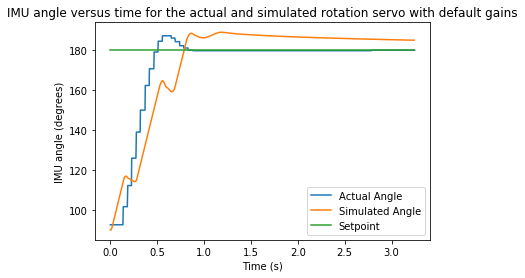

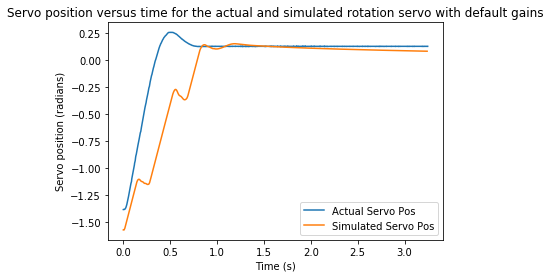

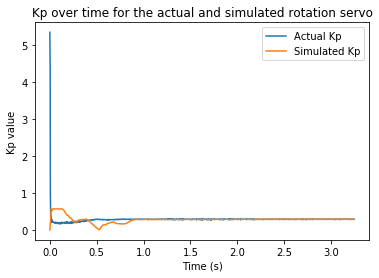

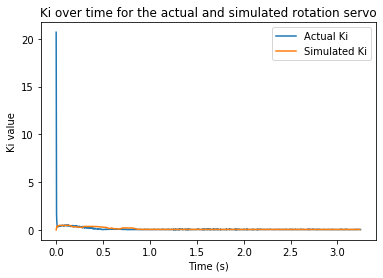

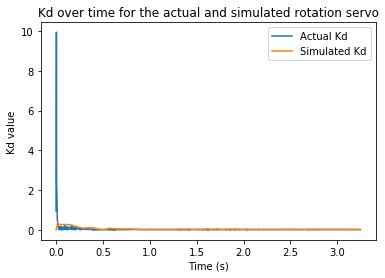

In [18]:
best_params = {'dt': 0.008, 'angle_delay': 0.12, 'saturation': 100, 'command_delay': 0.008} #No NN PID
test_actual_vs_sim(fname_actual_data_nn, best_params, use_nn=True, trained_model_file_name=fname_sim_model)

# Tuning the simulation again

Perform simulation tuning again, but use the data collected from the actual NN PID.

In [19]:
tune_simulation(fname_actual_data_nn, use_nn=True, trained_model_file_name=fname_sim_model)

0.037%, 0.074%, 0.112%, 0.149%, 0.186%, 0.223%, 0.260%, 0.298%, 0.335%, 0.372%, 0.409%, 0.446%, 0.484%, 0.521%, 0.558%, 0.595%, 0.632%, 0.670%, 0.707%, 0.744%, 0.781%, 0.818%, 0.856%, 0.893%, 0.930%, 0.967%, 1.004%, 1.042%, 1.079%, 1.116%, 1.153%, 1.190%, 1.228%, 1.265%, 1.302%, 1.339%, 1.376%, 1.414%, 1.451%, 1.488%, 1.525%, 1.562%, 1.600%, 1.637%, 1.674%, 1.711%, 1.749%, 1.786%, 1.823%, 1.860%, 1.897%, 1.935%, 1.972%, 2.009%, 2.046%, 2.083%, 2.121%, 2.158%, 2.195%, 2.232%, 2.269%, 2.307%, 2.344%, 2.381%, 2.418%, 2.455%, 2.493%, 2.530%, 2.567%, 2.604%, 2.641%, 2.679%, 2.716%, 2.753%, 2.790%, 2.827%, 2.865%, 2.902%, 2.939%, 2.976%, 3.013%, 3.051%, 3.088%, 3.125%, 3.162%, 3.199%, 3.237%, 3.274%, 3.311%, 3.348%, 3.385%, 3.423%, 3.460%, 3.497%, 3.534%, 3.571%, 3.609%, 3.646%, 3.683%, 3.720%, 3.757%, 3.795%, 3.832%, 3.869%, 3.906%, 3.943%, 3.981%, 4.018%, 4.055%, 4.092%, 4.129%, 4.167%, 4.204%, 4.241%, 4.278%, 4.315%, 4.353%, 4.390%, 4.427%, 4.464%, 4.501%, 4.539%, 4.576%, 4.613%, 4.650%, 

35.045%, 35.082%, 35.119%, 35.156%, 35.193%, 35.231%, 35.268%, 35.305%, 35.342%, 35.379%, 35.417%, 35.454%, 35.491%, 35.528%, 35.565%, 35.603%, 35.640%, 35.677%, 35.714%, 35.751%, 35.789%, 35.826%, 35.863%, 35.900%, 35.938%, 35.975%, 36.012%, 36.049%, 36.086%, 36.124%, 36.161%, 36.198%, 36.235%, 36.272%, 36.310%, 36.347%, 36.384%, 36.421%, 36.458%, 36.496%, 36.533%, 36.570%, 36.607%, 36.644%, 36.682%, 36.719%, 36.756%, 36.793%, 36.830%, 36.868%, 36.905%, 36.942%, 36.979%, 37.016%, 37.054%, 37.091%, 37.128%, 37.165%, 37.202%, 37.240%, 37.277%, 37.314%, 37.351%, 37.388%, 37.426%, 37.463%, 37.500%, 37.537%, 37.574%, 37.612%, 37.649%, 37.686%, 37.723%, 37.760%, 37.798%, 37.835%, 37.872%, 37.909%, 37.946%, 37.984%, 38.021%, 38.058%, 38.095%, 38.132%, 38.170%, 38.207%, 38.244%, 38.281%, 38.318%, 38.356%, 38.393%, 38.430%, 38.467%, 38.504%, 38.542%, 38.579%, 38.616%, 38.653%, 38.690%, 38.728%, 38.765%, 38.802%, 38.839%, 38.876%, 38.914%, 38.951%, 38.988%, 39.025%, 39.062%, 39.100%, 39.137%, 3

69.010%, 69.048%, 69.085%, 69.122%, 69.159%, 69.196%, 69.234%, 69.271%, 69.308%, 69.345%, 69.382%, 69.420%, 69.457%, 69.494%, 69.531%, 69.568%, 69.606%, 69.643%, 69.680%, 69.717%, 69.754%, 69.792%, 69.829%, 69.866%, 69.903%, 69.940%, 69.978%, 70.015%, 70.052%, 70.089%, 70.126%, 70.164%, 70.201%, 70.238%, 70.275%, 70.312%, 70.350%, 70.387%, 70.424%, 70.461%, 70.499%, 70.536%, 70.573%, 70.610%, 70.647%, 70.685%, 70.722%, 70.759%, 70.796%, 70.833%, 70.871%, 70.908%, 70.945%, 70.982%, 71.019%, 71.057%, 71.094%, 71.131%, 71.168%, 71.205%, 71.243%, 71.280%, 71.317%, 71.354%, 71.391%, 71.429%, 71.466%, 71.503%, 71.540%, 71.577%, 71.615%, 71.652%, 71.689%, 71.726%, 71.763%, 71.801%, 71.838%, 71.875%, 71.912%, 71.949%, 71.987%, 72.024%, 72.061%, 72.098%, 72.135%, 72.173%, 72.210%, 72.247%, 72.284%, 72.321%, 72.359%, 72.396%, 72.433%, 72.470%, 72.507%, 72.545%, 72.582%, 72.619%, 72.656%, 72.693%, 72.731%, 72.768%, 72.805%, 72.842%, 72.879%, 72.917%, 72.954%, 72.991%, 73.028%, 73.065%, 73.103%, 7

W0820 09:33:31.628740 14352 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 09:33:31.659771 14352 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 09:33:31.667714 14352 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0820 09:33:31.708640 14352 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0820 09:33:31.709638 14352 depre

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.3307729,1.8110133,1.1213136,-0.072563276,},{0.5261499,-0.662291,-1.144703,1.712379,},{0.28138128,0.053365517,1.9274986,-0.599831,},{-0.3581448,-1.6825196,0.0033206493,0.6985645,},{-0.2682502,-0.072796375,0.84237343,-1.378411,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{0.14616306,-1.5273558,0.35982278,-0.56100595,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{0.06499804,-0.030165646,-0.39896873,},{-0.28864387,-0.021510046,-0.27441448,},{-0.05190554,-0.19550289,0.049142517,},{-0.0063355123,-0.20068333,-0.28261405,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{0.17481682,-0.018585686,-0.04084195,}});
intermediate_index_1 =3;
intermediate_index_2 =3;


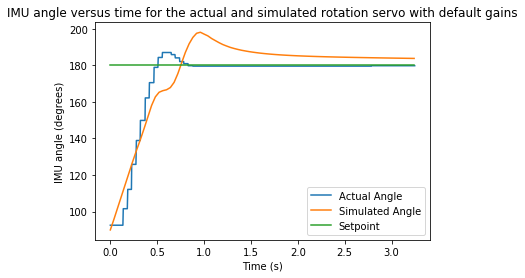

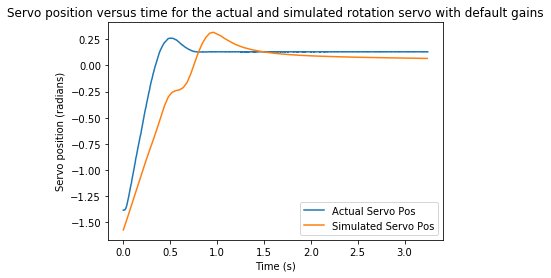

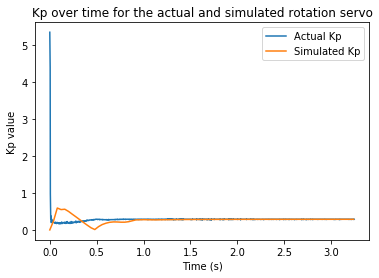

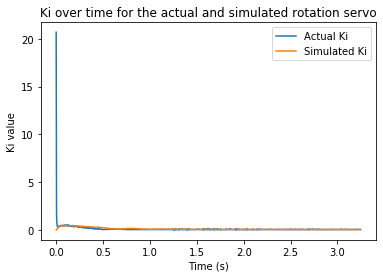

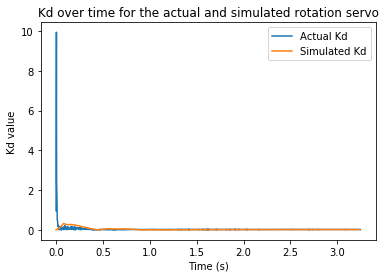

In [11]:
# best_params = {'dt': 0.01, 'angle_delay': 0.15, 'saturation': 90, 'command_delay': 0.002}
best_params = {'dt': 0.04, 'angle_delay': 0.15, 'saturation': 100, 'command_delay': 0.002}

test_actual_vs_sim(fname_actual_data_nn, best_params, use_nn=True, trained_model_file_name=fname_sim_model)

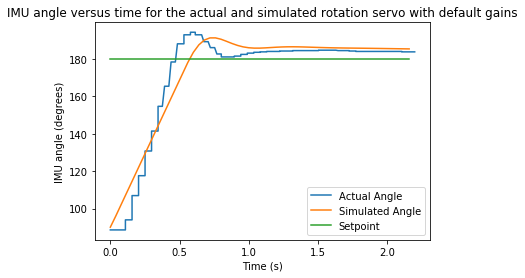

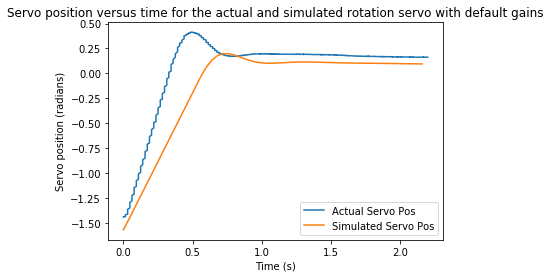

In [12]:
# best_params = {'dt': 0.01, 'angle_delay': 0.15, 'saturation': 90, 'command_delay': 0.002}
best_params = {'dt': 0.04, 'angle_delay': 0.15, 'saturation': 100, 'command_delay': 0.002}

test_actual_vs_sim(fname_actual_data_no_nn, best_params, use_nn=False)